# 미술관 작품 분류하기

Link : https://programmers.co.kr/skill_check_assignments/133

Code reference : https://prgms.tistory.com/75

# 고려한 사항
1. 데이터
2. 모델
3. 앙상블

# 환경설정
- 패키지 설정
- Config 설정

In [1]:
import os
import gc
import copy
import numpy as np
import pandas as pd
import easydict
from tqdm import notebook

# 이미지
from PIL import Image

# 시각화
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
import timm

In [3]:
config = {}

# 설정
config['seed'] = 42
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# 데이터
config['num_workers'] = 1
config['pin_memory'] = True

# 모델
config['hidden_dim'] = 128
config['dropout'] = 0.1

# 훈련
config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5

args = easydict.EasyDict(config)

# 데이터

## 데이터 룩업 테이블 만들기

In [4]:
PROJECT_PATH = 'data'
TRAIN_PATH = os.path.join(PROJECT_PATH, 'train')
TEST_PATH = os.path.join(PROJECT_PATH, 'test')

In [5]:
# label2idx
label2idx = {'dog': 0,
            'elephant': 1,
            'giraffe': 2,
            'guitar': 3,
            'horse': 4,
            'house': 5,
            'person': 6}

idx2label = {v: k for k, v in label2idx.items()}

In [6]:
# train_df 만들기
labels = []
for path in os.walk(TRAIN_PATH):
    label_type = path[0].split('\\')[-1]
    if label_type == 'train':
        continue
        
    base_path = path[0]
    images = path[2]
    
    idx = label2idx[label_type]
    for image in images:
        img_path = os.path.join(base_path, image)
        label = {'img_path': img_path,
                 'label': idx}
        labels.append(label)
        
train_df = pd.DataFrame(labels)
train_df = train_df.sort_values(['label', 'img_path'])
train_df = train_df.reset_index(drop=True)
train_df.head(5)

,img_path,label
0,data\train\dog\pic_001.jpg,0
1,data\train\dog\pic_002.jpg,0
2,data\train\dog\pic_003.jpg,0
3,data\train\dog\pic_004.jpg,0
4,data\train\dog\pic_005.jpg,0


In [7]:
for path in os.walk(TEST_PATH):
    print(path)

('data\\test', ['0'], [])
('data\\test\\0', [], ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '00

In [8]:
# test_df 만들기
labels = []
for path in os.walk(TEST_PATH):
    base_path = path[0]
    images = path[2]
    
    idx = label2idx[label_type]
    for image in images:
        img_path = os.path.join(base_path, image)
        label = {'img_path': img_path,
                 'label': -1}
        labels.append(label)
        
test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df = test_df.reset_index(drop=True)
test_df.head(5)

,img_path,label
0,data\test\0\0001.jpg,-1
1,data\test\0\0002.jpg,-1
2,data\test\0\0003.jpg,-1
3,data\test\0\0004.jpg,-1
4,data\test\0\0005.jpg,-1


## EDA

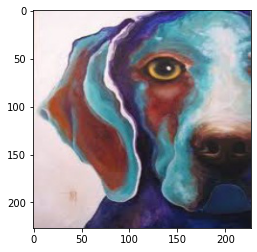

In [9]:
image = plt.imread(train_df['img_path'][0])
plt.imshow(image)

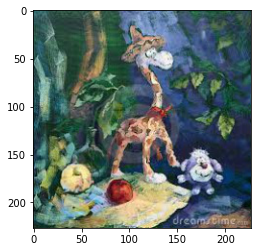

In [10]:
image = plt.imread(test_df['img_path'][0])
plt.imshow(image)

In [11]:
train_df.groupby('label').count()

,img_path
label,
0,329
1,205
2,235
3,134
4,151
5,245
6,399


In [12]:
test_df.count()

img_path    350
label       350
dtype: int64

## Dataset & DataLoader

In [13]:
class ArtDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        
        # 이미지
        img_path = data['img_path']
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            
        # 라벨
        label = data['label']
        
        return image, label
    
    def __len__(self):
        return len(self.df)

In [14]:
transform = transforms.Compose([transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                   [0.229, 0.224, 0.225])])

dataset = ArtDataset(train_df, transform)
dataset[7]

(tensor([[[ 1.6495,  1.6838,  1.7009,  ...,  0.8276,  0.6734,  0.7419],
          [ 1.6838,  1.7865,  1.8722,  ...,  0.8276,  0.6563,  0.6563],
          [ 1.6838,  1.9235,  2.0605,  ...,  0.9474,  0.6563,  0.6049],
          ...,
          [-1.3644, -1.6042, -1.6555,  ..., -1.6213, -1.6727, -1.7069],
          [-1.2959, -1.5699, -1.7754,  ..., -1.7925, -1.8782, -1.8268],
          [-1.4158, -1.7069, -1.7583,  ..., -1.9980, -2.0152, -1.9809]],
 
         [[ 1.7458,  1.7983,  1.8508,  ...,  0.2227,  0.2227,  0.3102],
          [ 1.7808,  1.8859,  2.0259,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.7633,  2.0259,  2.2185,  ...,  0.1527, -0.0399, -0.1099],
          ...,
          [-1.4580, -1.7031, -1.7731,  ..., -1.6856, -1.6155, -1.6506],
          [-1.3704, -1.6681, -1.8782,  ..., -1.8256, -1.8081, -1.7556],
          [-1.4930, -1.8081, -1.8606,  ..., -2.0357, -1.9482, -1.9132]],
 
         [[ 1.4548,  1.4722,  1.5245,  ..., -1.3861, -1.2467, -1.1247],
          [ 1.5245,  1.5942,

In [15]:
loader = DataLoader(dataset, shuffle=True, batch_size=32)

for x, y in loader:
    print(x, y)
    break

tensor([[[[ 1.5468,  1.5297,  1.4954,  ...,  1.3070,  1.3070,  1.3755],
          [ 1.5639,  1.5468,  1.5297,  ...,  1.2214,  1.2728,  1.3755],
          [ 1.5810,  1.5639,  1.5468,  ...,  1.2043,  1.2385,  1.3242],
          ...,
          [ 0.8276,  0.8104,  0.7933,  ...,  0.1083,  0.1426,  0.1768],
          [ 0.8276,  0.7933,  0.7591,  ...,  0.2282,  0.1768,  0.1254],
          [ 0.8276,  0.8104,  0.7762,  ...,  0.2624,  0.1768,  0.1254]],

         [[ 1.6933,  1.6758,  1.6408,  ...,  1.4832,  1.6408,  1.7108],
          [ 1.7108,  1.6933,  1.6758,  ...,  1.3957,  1.6057,  1.7108],
          [ 1.7283,  1.7108,  1.6933,  ...,  1.3782,  1.5707,  1.6583],
          ...,
          [ 0.8880,  0.8704,  0.8529,  ...,  0.2752,  0.3102,  0.3452],
          [ 0.8880,  0.8529,  0.8179,  ...,  0.3277,  0.3277,  0.2752],
          [ 0.8880,  0.8704,  0.8354,  ...,  0.3627,  0.3277,  0.2752]],

         [[ 1.8208,  1.8034,  1.7685,  ...,  1.5942,  1.7163,  1.7860],
          [ 1.8383,  1.8208,  

## train / valid 나누기
stratifiedKFold 적용

In [16]:
from sklearn.model_selection import StratifiedKFold

def split_df(df, kfold_n=5):
    kfold = StratifiedKFold(n_splits=kfold_n)

    # 클래스 비율 고려하여 Fold별로 데이터 나눔
    X = df.img_path.values
    y = df.label.values

    datas = []
    for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_index].copy().reset_index(drop=True)
        valid_df = df.iloc[valid_index].copy().reset_index(drop=True)

        datas.append((train_df, valid_df))

    return datas

In [17]:
datas = split_df(train_df)

In [18]:
# 첫번째 데이터셋 train
datas[0][0].groupby('label').count()

,img_path
label,
0,263
1,164
2,188
3,107
4,121
5,196
6,319


In [19]:
# 첫번째 데이터셋 valid
datas[0][1].groupby('label').count()

,img_path
label,
0,66
1,41
2,47
3,27
4,30
5,49
6,80


### get_loader

In [20]:
def get_loader(train_data, valid_data, transform):
    train_dataset = ArtDataset(train_data, transform)
    valid_dataset = ArtDataset(valid_data, transform)


    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=args.num_workers,
                              batch_size=args.batch_size,
                              pin_memory=args.pin_memory)
    valid_loader = DataLoader(valid_dataset,
                              shuffle=False,
                              num_workers=args.num_workers,
                              batch_size=args.batch_size,
                              pin_memory=args.pin_memory)
    
    return train_loader, valid_loader

# 모델
- Conv 모델
- EfficientNet1
- Timm

In [21]:
for X, y in loader:
    print(X.size(), y.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


## Conv 모델

간단한 ConvNet으로 테스트

In [22]:
class ConvNet(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()

        self.model = nn.Sequential(
            # [32, 3, 224, 224] -> [32, 32, 55, 55]
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [32, 64, 55, 55] -> [32, 64, 27, 27]

            # [32, 32, 27, 27] -> [32, 64, 11, 11]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [32, 64, 11, 11] -> [32, 64, 5, 5]
        )
        self.fc = nn.Linear(1600, class_n)


    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [23]:
model = ConvNet(args)
model(X)

tensor([[ 5.2502e-01,  5.1822e-01,  7.8503e-01, -9.0162e-01,  4.1312e-01,
         -1.9738e-01,  3.6838e-01],
        [ 3.8532e-01,  6.8693e-01, -5.6254e-01,  3.8825e-02, -3.5252e-01,
         -3.9468e-02, -5.4959e-02],
        [ 4.0314e-01,  3.8231e-01, -1.1983e-01, -4.2813e-01,  2.5056e-01,
          1.4222e-01,  5.0084e-01],
        [ 5.3879e-01,  3.6967e-01, -1.0256e+00, -7.2418e-01, -5.3736e-01,
         -6.5143e-01,  7.9157e-01],
        [ 1.0799e+00,  1.0907e-01,  5.2667e-01, -2.9815e-01, -2.5993e-01,
         -5.0506e-01,  1.3415e-01],
        [ 1.0295e+00,  3.7971e-01, -1.9892e-01,  5.2846e-01, -3.5549e-01,
         -1.0246e+00,  3.6299e-01],
        [ 1.8547e-01,  3.4118e-01,  5.3346e-01, -1.2114e-01,  4.4045e-01,
         -8.5388e-01,  2.9623e-01],
        [ 8.9860e-01,  5.3046e-01,  1.3364e-01, -1.8076e-01,  2.7536e-01,
         -2.3881e-02,  2.1016e-01],
        [ 7.1095e-01,  2.9953e-01,  5.2786e-01, -5.1833e-01,  7.4621e-02,
         -9.4464e-01,  4.2441e-01],
        [ 

## EfficientNet1

In [24]:
class Eff01(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1', pretrained=True, num_classes=class_n)

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = Eff01(args)
model(X)

tensor([[ -1.6292,   1.0930,  -1.5754,  -0.4981,   0.6995,  -4.6865,   1.9831],
        [ -2.2869,  -1.3472,  -2.2006,  -0.9785,   4.5150,   1.0848,   0.2327],
        [ -2.5669,  -1.1323,   2.2238,   2.1327,  -6.3595,  -0.4423,   1.0469],
        [ -2.0508,   0.9853,   1.0731,  -0.5225,  -0.7677,  -1.4207,  -4.3933],
        [  0.1444,   1.9682,   2.6051,  -1.9708,  -1.0975,  -1.2582,   0.4859],
        [ -2.1109,  -4.0969,  -2.2574,   3.7919,   1.0097,   1.1745,  -4.7649],
        [ -4.9553,  -0.9226,   0.8697,  -5.3629,  -1.6793,  -2.8611,  -5.2768],
        [  2.4146,  -2.4449,  -3.9738,  -1.7283,   0.7427,  -1.7446,  -2.4587],
        [ -6.0343,   0.1373,   2.2551,  -4.3106,   2.6855,   3.3893,  -2.0287],
        [ -4.1556,  -6.2354,   2.9927,   1.6465,   4.0482,  -3.9065,   0.7752],
        [  1.7959,  -2.3622,  -4.7508,   2.3053,  -4.5866,  -4.2772,  -2.5500],
        [  1.0012,   1.2830,  -1.0618,   0.1000,   0.0734,   5.2029,   2.0137],
        [ -1.4237,   3.8616,  -0.4829,  

## Timm

timm 이 제공하는 다양한 모델을 args 패러미터로 가져오기 위한 모델

In [26]:
class Timm(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()
        self.model = timm.create_model(args.timm_model, pretrained=True, num_classes=class_n)

    def forward(self, x):
        x = self.model(x)
        return x

# 훈련

In [27]:
config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['model_path'] = 'model'

# 데이터
config['num_workers'] = 0
config['pin_memory'] = False

# 모델
config['dropout'] = 0.1

# 훈련
config['n_epochs'] = 20
config['lr'] = 0.0001
config['batch_size'] = 32
config['clip_grad'] = 10
config['log_steps'] = 20
config['patience'] = 10

config['model'] = 'timm'
config['timm_model'] = 'vit_deit_base_distilled_patch16_224'

config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'

config['load'] = False
config['model_name'] = ""

config['kfold'] = 1

config['pseudo_labeling'] = False
config['pseudo_iter_n'] = 2

args = easydict.EasyDict(config)

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'convnet': model = ConvNet(args)
    if args.model == 'eff1': model = Eff01(args)
    if args.model == 'eff3': model = Eff03(args)
    if args.model == 'timm': model = Timm(args)

    model.to(args.device)

    return model

In [30]:
def get_optimizer(model, args):
    if args.optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.0)
    
    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()
    
    return optimizer

In [31]:
def get_scheduler(optimizer, args):
    if args.scheduler == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5, mode='max', verbose=True)

    return scheduler

In [32]:
def train(args, model, train_loader, optimizer):
    model.train()

    corrects = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(args.device)
        labels = labels.to(args.device)

        outputs = model(images)
        if args.timm_model == 'vit_deit_base_distilled_patch16_224':
            outputs = outputs[0]
        
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")

        _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == labels.data)

    acc = corrects / args.train_len

    return acc

In [33]:
def validate(args, model, valid_loader):
    model.eval()

    corrects = 0

    for images, labels in valid_loader:
        images = images.to(args.device)
        labels = labels.to(args.device)
        

        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    acc = corrects / args.valid_len

    print(f'VALID ACC : {acc}\n')

    return acc, outputs

In [34]:
def pseudo_labeling(args, model, train_data):
    # train_data에 새로운 df
    new_train_data = copy.deepcopy(test_df)

    test_dataset = ArtDataset(test_df, transform)
    test_loader = DataLoader(test_dataset,
                            shuffle=False,
                            num_workers=args.num_workers,
                            batch_size=args.batch_size,
                            pin_memory=args.pin_memory)
    model.eval()
    answers = []
    for images, labels in test_loader:
        images = images.to(args.device)
        labels = labels.to(args.device)

        outputs = model(images)

        _, preds = torch.max(outputs, 1)

        answers.extend(list(preds.cpu().numpy()))

    new_train_data.label = answers

    new_train_data = pd.concat([train_data, new_train_data]).reset_index(drop=True)

    return new_train_data

In [35]:
def run(args, train_data, valid_data):
    """데이터셋을 주면 처음부터 끝까지 훈련 사이클을 실행"""

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()
    
    # 데이터 로드
    args.train_len = len(train_data) 
    args.valid_len = len(valid_data) 
    transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    train_loader, valid_loader = get_loader(train_data, valid_data, transform)

    if args.load:
        model = torch.load(os.path.join(args.model_path, args.model_name))
    else:
        model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    early_stopping_counter = 0
    best_acc = -1

    if args.pseudo_labeling:
        iter_n = args.pseudo_iter_n
    else:
        iter_n = 1

    # pseudo labeling을 위한 iteration
    for iter_i in range(iter_n):
        for epoch in notebook.tqdm(range(args.n_epochs)):
            print(f'Epoch {epoch + 1}/{args.n_epochs}')

            ### TRAIN
            train_acc = train(args, model, train_loader, optimizer)

            ### VALID
            valid_acc, outputs = validate(args, model, valid_loader)

            ### model save and early stopping
            if valid_acc > best_acc:
                best_acc = valid_acc
                early_stopping_counter = 0
                
                # 모델 저장!
                if args.model == 'timm':
                    save_name = f"{args.timm_model}_fold{args.kfold}_{str(best_acc.item())[:4]}"
                else:
                    save_name = f"{args.model}_fold{args.kfold}_{str(best_acc.item())[:4]}"

                torch.save(model, os.path.join(args.model_path, save_name))
                print(f'model saved! {save_name}')
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                    break     

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_acc)

        # Pseudo Labeling
        if args.pseudo_labeling:
            print('pseudo labeing ongoing!')
            train_data = pseudo_labeling(args, model, train_data)

            # make a loader with new train data
            train_loader, _ = get_loader(train_data, valid_data, transform)

### 데이터 불러오기

In [36]:
datas = split_df(train_df)

# 하나의 fold만 사용
train_data = datas[args.kfold - 1][0]
valid_data = datas[args.kfold - 1][1]

### 훈련 진행

In [37]:
args.lr = 0.0001
args.load = False
args.model_name = ''

args.batch_size = 8
args.log_steps = 20

args.patience = 10

In [38]:
timm.list_models(pretrained=True)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [39]:
args.timm_model = 'visformer_small'
# args.timm_model = 'ecaresnet50t'
# args.timm_model = 'seresnext50_32x4d'
# args.timm_model = 'tf_efficientnet_b3_ns'
# args.timm_model = 'eca_nfnet_l0'
# args.timm_model = 'resnest50d'
# args.timm_model = 'regnety_016'

In [40]:
# pseudo labeling
args.pseudo_labeling = True
args.pseudo_iter_n = 3

args.n_epochs = 3

In [41]:
run(args, train_data, valid_data)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 2.0238428115844727
Training steps: 20 Loss: 0.5934919714927673
Training steps: 40 Loss: 1.535945177078247
Training steps: 60 Loss: 1.195387601852417
Training steps: 80 Loss: 0.27136799693107605
Training steps: 100 Loss: 1.020337462425232
Training steps: 120 Loss: 0.12521876394748688
Training steps: 140 Loss: 0.022513702511787415
Training steps: 160 Loss: 0.46866998076438904
VALID ACC : 0.9205882549285889

model saved! visformer_small_fold1_0.92
Epoch 2/3
Training steps: 0 Loss: 0.1387157291173935
Training steps: 20 Loss: 0.24851182103157043
Training steps: 40 Loss: 0.09302818775177002
Training steps: 60 Loss: 0.25219687819480896
Training steps: 80 Loss: 0.17806822061538696
Training steps: 100 Loss: 0.13321708142757416
Training steps: 120 Loss: 0.02494630217552185
Training steps: 140 Loss: 0.05067143589258194
Training steps: 160 Loss: 0.09509057551622391
VALID ACC : 0.9147058725357056

Epoch 3/3
Training steps: 0 Loss: 0.1048254445195198
Training steps:

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.1374252736568451
Training steps: 20 Loss: 0.0808117687702179
Training steps: 40 Loss: 0.17079900205135345
Training steps: 60 Loss: 0.18529872596263885
Training steps: 80 Loss: 0.026092367246747017
Training steps: 100 Loss: 0.898637592792511
Training steps: 120 Loss: 0.11658245325088501
Training steps: 140 Loss: 0.02289140596985817
Training steps: 160 Loss: 0.042572055011987686
Training steps: 180 Loss: 0.06945009529590607
Training steps: 200 Loss: 0.06060589849948883
VALID ACC : 0.9676470756530762

model saved! visformer_small_fold1_0.96
Epoch 2/3
Training steps: 0 Loss: 0.02162322588264942
Training steps: 20 Loss: 0.06640543043613434
Training steps: 40 Loss: 0.006967802066355944
Training steps: 60 Loss: 0.034368809312582016
Training steps: 80 Loss: 0.8070324659347534
Training steps: 100 Loss: 0.0032344325445592403
Training steps: 120 Loss: 0.8620463013648987
Training steps: 140 Loss: 0.22977109253406525
Training steps: 160 Loss: 0.036785535514354706

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.027236664667725563
Training steps: 20 Loss: 0.5180121660232544
Training steps: 40 Loss: 1.1349525451660156
Training steps: 60 Loss: 0.10098159313201904
Training steps: 80 Loss: 0.01638142392039299
Training steps: 100 Loss: 0.02833532728254795
Training steps: 120 Loss: 0.565388560295105
Training steps: 140 Loss: 0.2719168961048126
Training steps: 160 Loss: 0.05348744988441467
Training steps: 180 Loss: 0.07842635363340378
Training steps: 200 Loss: 0.05470511317253113
Training steps: 220 Loss: 0.9433779120445251
Training steps: 240 Loss: 0.2801077961921692
VALID ACC : 0.9264705777168274

Epoch 2/3
Training steps: 0 Loss: 0.020185526460409164
Training steps: 20 Loss: 0.26761874556541443
Training steps: 40 Loss: 0.04683682695031166
Training steps: 60 Loss: 0.24886953830718994
Training steps: 80 Loss: 0.009207461029291153
Training steps: 100 Loss: 0.3414607048034668
Training steps: 120 Loss: 0.024159494787454605
Training steps: 140 Loss: 0.0058744484558701

## 추론

In [42]:
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                         shuffle=False,
                         num_workers=args.num_workers,
                         batch_size=args.batch_size,
                         pin_memory=args.pin_memory)

In [43]:
torch.cuda.empty_cache()
gc.collect()

334

In [46]:
#infer_model_name = 'timm_0.99'
#infer_model_name = 'ecaresnet50t_0.98'
infer_model_name = 'visformer_small_fold1_0.96'


model = torch.load(os.path.join(args.model_path, infer_model_name))

In [47]:
model.eval()
answers = []
for images, labels in test_loader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    outputs = model(images)

    _, preds = torch.max(outputs, 1)

    answers.extend(list(preds.cpu().numpy()))

In [48]:
answers

[6,
 3,
 3,
 6,
 3,
 3,
 4,
 4,
 3,
 1,
 6,
 2,
 2,
 2,
 3,
 1,
 2,
 0,
 6,
 3,
 3,
 5,
 2,
 6,
 0,
 5,
 1,
 2,
 0,
 5,
 1,
 5,
 6,
 2,
 0,
 5,
 5,
 4,
 5,
 1,
 4,
 0,
 2,
 3,
 1,
 3,
 0,
 5,
 5,
 2,
 6,
 5,
 4,
 1,
 5,
 0,
 4,
 5,
 1,
 6,
 5,
 0,
 6,
 1,
 1,
 2,
 4,
 1,
 1,
 3,
 2,
 3,
 4,
 1,
 1,
 6,
 2,
 0,
 3,
 4,
 1,
 6,
 1,
 6,
 6,
 4,
 3,
 6,
 1,
 2,
 2,
 5,
 1,
 0,
 5,
 6,
 3,
 3,
 1,
 6,
 5,
 6,
 6,
 0,
 3,
 2,
 5,
 3,
 0,
 0,
 4,
 6,
 2,
 5,
 4,
 2,
 0,
 1,
 5,
 6,
 4,
 2,
 2,
 6,
 1,
 1,
 5,
 6,
 0,
 4,
 1,
 0,
 6,
 4,
 4,
 2,
 5,
 6,
 5,
 0,
 4,
 3,
 1,
 5,
 6,
 5,
 4,
 0,
 2,
 5,
 6,
 1,
 6,
 3,
 2,
 2,
 0,
 1,
 4,
 5,
 2,
 4,
 6,
 2,
 3,
 4,
 1,
 5,
 6,
 2,
 1,
 5,
 3,
 0,
 0,
 3,
 2,
 5,
 5,
 4,
 2,
 0,
 3,
 6,
 0,
 3,
 3,
 2,
 6,
 4,
 4,
 1,
 2,
 4,
 4,
 6,
 6,
 6,
 3,
 2,
 5,
 5,
 4,
 6,
 2,
 1,
 3,
 6,
 0,
 2,
 3,
 1,
 1,
 3,
 1,
 5,
 0,
 2,
 0,
 0,
 0,
 6,
 2,
 2,
 6,
 4,
 3,
 2,
 5,
 4,
 3,
 5,
 4,
 0,
 4,
 6,
 0,
 6,
 4,
 0,
 6,
 1,
 2,
 1,
 6,
 0,
 5,
 4,
 6,
 3,


In [50]:
submission_path = os.path.join('submission', 'submission.csv')
submission_df = pd.DataFrame({'answer_value': answers})
submission_df.to_csv(submission_path)

In [51]:
submission_df.value_counts()

answer_value
6               61
5               51
2               49
4               48
0               47
1               47
3               47
dtype: int64

### 앙상블

KFold 앙상블

In [52]:
#args.timm_model = 'vit_deit_base_distilled_patch16_224'
# args.timm_model = 'ecaresnet50t'
# args.timm_model = 'seresnext50_32x4d'
args.timm_model = 'tf_efficientnet_b3_ns'
# args.timm_model = 'eca_nfnet_l0'
# args.timm_model = 'resnest50d'
# args.timm_model = 'regnety_016'

In [62]:
args.lr = 0.0001
args.load = False
args.model_name = ''

args.batch_size = 8
args.log_steps = 20

args.patience = 5

In [66]:
kfold_n = 5
datas = split_df(train_df)
for fold in range(1, kfold_n + 1):
    args.kfold = fold

    # 하나의 fold만 사용
    train_data = datas[args.kfold - 1][0]
    valid_data = datas[args.kfold - 1][1]
    run(args, train_data, valid_data)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 2.9007444381713867
Training steps: 20 Loss: 2.295630931854248
Training steps: 40 Loss: 1.7649180889129639
Training steps: 60 Loss: 0.13025908172130585
Training steps: 80 Loss: 0.3805244565010071
Training steps: 100 Loss: 0.1770177036523819
Training steps: 120 Loss: 0.43627914786338806
Training steps: 140 Loss: 0.456304132938385
Training steps: 160 Loss: 0.3081406354904175


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 6.06 GiB already allocated; 12.62 MiB free; 6.12 GiB reserved in total by PyTorch)

## Soft Voting

In [65]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
models = [
        #   "vit_deit_base_distilled_patch16_224_fold1_pseudo_0.97",
          "vit_deit_base_distilled_patch16_224_0.97",
          "vit_deit_base_distilled_patch16_224_0.99",
          "vit_deit_base_distilled_patch16_224_fold1_0.98",
          "vit_deit_base_distilled_patch16_224_fold2_0.98",
          "vit_deit_base_distilled_patch16_224_fold3_0.97",
          "vit_deit_base_distilled_patch16_224_fold4_0.97",
          "vit_deit_base_distilled_patch16_224_fold5_0.95"]

models = [torch.load(os.path.join(args.model_path, model)).eval() for model in models]

In [ ]:
args.batch_size = 2
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                         shuffle=False,
                         num_workers=args.num_workers,
                         batch_size=args.batch_size,
                         pin_memory=args.pin_memory)

In [ ]:
answers = []
for images, labels in test_loader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    predicts = torch.zeros(images.size(0), 7)
    for model in models:
        outputs = model(images)
        outputs = F.softmax(outputs.cpu(), dim=1)
        predicts += outputs

    # prediction들의 average 계산
    predict_avg = predicts / len(models)

    _, preds = torch.max(predict_avg, 1)

    answers.extend(list(preds.cpu().numpy()))